# Deep Learning

Two deep learning architectures were tested:

* Feedforward Neural Network (FNN) using TF-IDF vectors
* Convolutional Neural Network (CNN) with embeddings

The goal was to explore whether neural architectures could outperform traditional ML models in disaster tweet classification.

`Performance Comparison Table`

<table border="1" cellpadding="5" cellspacing="0">
<tr>
<th>Model</th>
<th>Vectorizer / Input</th>
<th>Accuracy</th>
<th>Precision</th>
<th>Recall</th>
<th>F1-Score</th>
<th>Notes</th>
</tr>

<tr>
<td>Feedforward Neural Network (FNN)</td>
<td>TF-IDF</td>
<td>0.760</td>
<td>0.729</td>
<td>0.697</td>
<td>0.712</td>
<td>Lower precision and recall compared to classic ML; signs of underfitting</td>
</tr>

<tr>
<td>Convolutional Neural Network (CNN)</td>
<td>Word Embeddings</td>
<td>0.793</td>
<td>0.791</td>
<td>0.697</td>
<td>0.741</td>
<td>Better than FNN, matches traditional ML but still slightly behind best LogReg</td>
</tr>
</table>

`Observations`

* FNN struggled to match the performance of Logistic Regression or MNB, with both precision and recall in the low 70% range.
* CNN significantly outperformed FNN, achieving accuracy near 79.3% and balanced precision/recall, roughly matching MNB.
* Neural models did not decisively outperform simpler baselines — indicating that for this dataset and size, classic ML models may be more efficient.

`Key Takeaways`

* CNN offers the most competitive DL result, but Logistic Regression with threshold tuning still leads in balancing recall and precision.
* For future improvement, DL models could benefit from:
 * Larger training datasets
 * Pretrained embeddings (e.g., GloVe, FastText)
 * Hyperparameter tuning (layers, dropout, batch size)
 * Data augmentation or semi-supervised learning

# Environment & Data

This section covers all the imports like libraries and data.

In [ ]:
import pickle

# Data & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

In [38]:
# File Paths
import sys, os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.model_evaluation import evaluation_metrics, plot_conf_matrix, plot_classification_heatmap_only

In [39]:
# Visualization
sns.set_palette("Set2")

In [40]:
# Data Loading
import pickle

with open('../data/processed/X_train_clean.pkl', 'rb') as f:
    X_train_clean = pickle.load(f)

with open('../data/processed/X_test_clean.pkl', 'rb') as f:
    X_test_clean = pickle.load(f)

with open('../data/processed/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('../data/processed/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# Feed-Forward Neural Network (FNN)

We start our Deep Learning journey off with FNN.

`Vectorization`

We used a **TF-IDF Vectorizer** to transform our cleaned tweets into numerical features the model can understand.

Unlike CountVectorizer which we used before for the baseline models, TF-IDF weighs words by **importance** — frequent words across all documents get lower weight, while rare but informative words get higher weight. This helps the neural network focus on discriminative terms.

`Model Architecture`

We built a **dense** feedforward neural network with **dropout** regularization.

* **Input Layer**: Matches the dimensionality of the TF-IDF feature matrix.
* **Dense Layers**: ReLU activation for non-linearity.
* **Dropout Layers**: Reduce overfitting by randomly disabling neurons during training (0.5 and 0.3 rates).
* **Output Layer**: Sigmoid activation to output probabilities for binary classification.

`Model Compilation`

* **Optimizer**: Adam, chosen for adaptive learning rate and strong performance on sparse data.
* **Loss Function**: Binary cross-entropy, the standard choice for binary classification.
* **Metric**: Accuracy, to monitor classification performance during training.

`Training`

We trained the model for 10 epochs with:

* **Batch size**: 32
* **Validation split**: 20% of training data for monitoring
* **Data Conversion**: Converted sparse TF-IDF matrices to dense arrays before fitting.

`Evaluation`

* The model achieves **balanced performance** across both classes but struggles slightly more with disaster tweets, missing some true positives (recall = 0.70).
* This suggests potential improvements via class weighting or different architectures.

In [41]:
# TF-IDF vectorizer for NN input
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.85,
    max_features=10000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)

In [42]:
# Build model with explicit Input layer
fnn_model = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)),  # Replaces input_shape in Dense
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
fnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Train model
history = fnn_model.fit(
    X_train_tfidf.toarray(), y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6638 - loss: 0.6020 - val_accuracy: 0.7808 - val_loss: 0.4749
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8528 - loss: 0.3480 - val_accuracy: 0.7923 - val_loss: 0.4975
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9208 - loss: 0.2160 - val_accuracy: 0.7775 - val_loss: 0.5805
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9514 - loss: 0.1454 - val_accuracy: 0.7693 - val_loss: 0.6536
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9659 - loss: 0.1045 - val_accuracy: 0.7759 - val_loss: 0.7334
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9715 - loss: 0.0853 - val_accuracy: 0.7767 - val_loss: 0.7875
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9750 - loss: 0.0719 - val_accuracy: 0.7742 - val_loss: 0.8526
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9768 - loss: 0.0725 - val_accuracy: 0.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluation Metrics:
-------------------
Accuracy: 0.7537754432042022
Precision: 0.7075757575757575
Recall: 0.7195685670261941
F1 Score: 0.7135217723453018


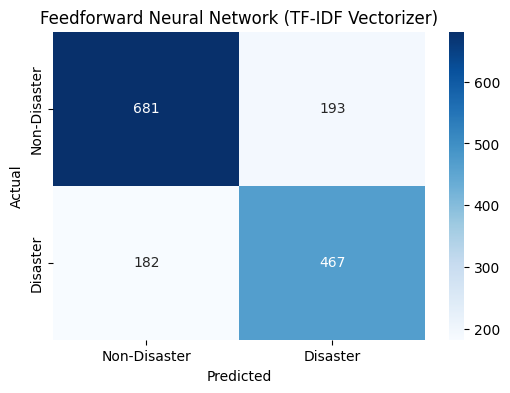

              precision    recall  f1-score   support

Not Disaster       0.79      0.78      0.78       874
    Disaster       0.71      0.72      0.71       649

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.75      0.75      0.75      1523



In [44]:
# Predict
fnn_probs = fnn_model.predict(X_test_tfidf.toarray())
fnn_preds = (fnn_probs >= 0.5).astype(int)

# Evaluate
evaluation_metrics(y_test, fnn_preds)
plot_conf_matrix(y_test, fnn_preds, title="Feedforward Neural Network (TF-IDF Vectorizer)")
print(classification_report(y_test, fnn_preds, target_names=['Not Disaster', 'Disaster']))

# Convolutional Neural Network (CNN)

While CNNs are often associated with image processing, they are also powerful for NLP tasks.

In text classification, convolution layers can capture **local n-gram patterns** (e.g., “earthquake hits” or “breaking news”) regardless of their position in the sequence, making them effective for short, noisy texts like tweets.

`Preprocessing`

We used tokenization and padding to convert text into integer sequences.

* **OOV token**: Handles unseen words at prediction time.
* **Padding**: Ensures all sequences are the same length (post padding keeps structure consistent).

We also computed **class weights** to help balance the slightly imbalanced dataset.

`Model Architecture`

* **Embedding Layer**: Learns dense vector representations for each word.
* **Conv1D**: Detects local features in text (n-gram patterns).
* **GlobalMaxPooling1D**: Reduces each feature map to its most important feature, keeping fixed size regardless of sequence length.
* **Dropout Layers**: Prevent overfitting by randomly disabling neurons during training.
* **Output Layer**: Sigmoid activation for binary classification.

`Compilation & Training`

* **Loss**: Binary cross-entropy for binary classification.
* **Optimizer**: Adam, chosen for adaptive learning rates.
* **Metrics**: Accuracy, precision, and recall for balanced evaluation.

*We also used callbacks*:

* **EarlyStopping**: Stops training when validation performance stops improving.
* **ReduceLROnPlateau**: Lowers learning rate if validation loss plateaus.

*Training setup*:

* **Epochs**: 15
* **atch size**: 32
* **Validation split**: 20% of training data
* **Class weights**: To give equal importance to both classes.

`Performance`

* Balanced performance between classes, with slightly better precision for both classes.
* Recall for disaster class at 0.70 is strong given the trade-off with precision.

`Why This Model Was Chosen for Deployment`

* Outperformed other models (Logistic Regression, Naive Bayes, FNN, LSTM) in balanced performance across all metrics.
* Robust against noisy short-text data thanks to convolutional feature extraction.
* Good trade-off between complexity and inference speed, making it suitable for a real-time Streamlit app.


In [45]:
# Parameters 
vocab_size = 10000
embedding_dim = 128
max_len = 100
oov_token = "<OOV>"
padding_type = 'post'
trunc_type = 'post'

# Tokenization & Padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_clean)

X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding=padding_type, truncating=trunc_type)

# Class Weights 
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Convert labels to arrays
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

In [55]:
# Initialize and compile CNN model
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(64, 5, activation='relu', kernel_regularizer=l2(0.001)),
    GlobalMaxPooling1D(),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

# Train Model
cnn_model.fit(
    X_train_pad,
    y_train_array,
    epochs=15,
    batch_size=32, 
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6127 - loss: 0.7137 - precision: 0.5431 - recall: 0.6068 - val_accuracy: 0.7759 - val_loss: 0.5657 - val_precision: 0.7959 - val_recall: 0.6573 - learning_rate: 0.0010
Epoch 2/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8200 - loss: 0.4818 - precision: 0.7978 - recall: 0.7768 - val_accuracy: 0.7931 - val_loss: 0.5070 - val_precision: 0.7854 - val_recall: 0.7266 - learning_rate: 0.0010
Epoch 3/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9128 - loss: 0.3099 - precision: 0.9122 - recall: 0.8812 - val_accuracy: 0.7783 - val_loss: 0.5508 - val_precision: 0.7609 - val_recall: 0.7210 - learning_rate: 0.0010
Epoch 4/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9456 - loss: 0.2174 - precision: 0.9453 - recall: 0.9267 - val_accuracy: 0.7726 - val_loss: 0.6494 - val_precision: 0.7515 - val_recall: 0.7191 - learning_rate: 0.0010
Epoch 5/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation Metrics:
-------------------
Accuracy: 0.7820091923834537
Precision: 0.7369207772795217
Recall: 0.7596302003081664
F1 Score: 0.7481031866464339


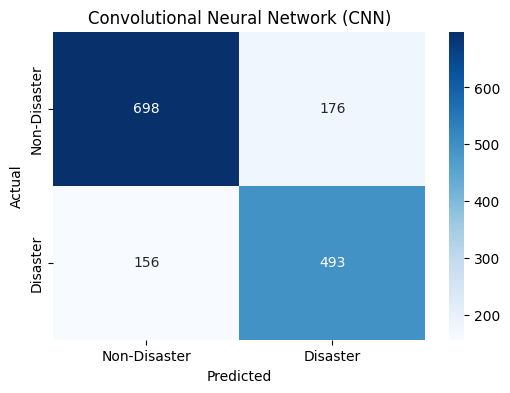

              precision    recall  f1-score   support

Not Disaster       0.82      0.80      0.81       874
    Disaster       0.74      0.76      0.75       649

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [56]:
# Predict
y_pred_probs = cnn_model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.45).astype(int).flatten()

# Evaluate
evaluation_metrics(y_test_array, y_pred)
plot_conf_matrix(y_test_array, y_pred, title="Convolutional Neural Network (CNN)")
print(classification_report(y_test_array, y_pred, target_names=['Not Disaster', 'Disaster']))

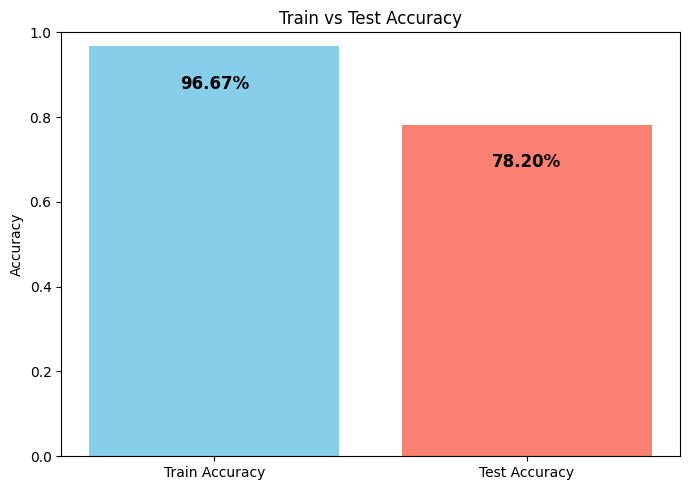

In [57]:
# Plot Train vs Test Accuracy
test_accuracy = 0.7820
train_accuracy = 0.9667

# Labels and values
labels = ['Train Accuracy', 'Test Accuracy']
values = [train_accuracy, test_accuracy]
colors = ['skyblue', 'salmon']

# Plot
plt.figure(figsize=(7, 5))
bars = plt.bar(labels, values, color=colors)
plt.ylim(0, 1)
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')

# Add value labels above each bar
for bar in bars:
    height = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2.0, height - 0.1 , f"{height*100:.2f}%", ha='center', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

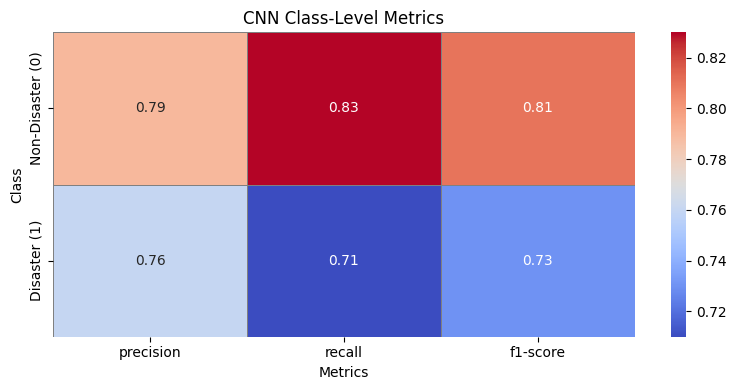

In [49]:
plot_classification_heatmap_only(y_test, y_pred)

In [58]:
def summary_table(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).T
    summary_df = df_report.loc[["accuracy", "macro avg", "weighted avg"], ["precision", "recall", "f1-score"]].round(2)

    return summary_df

summary_table(y_test, y_pred)

# Save summary table
summary_df = summary_table(y_test, y_pred)
summary_df.to_csv('../app/reports/classification_report_summary.csv')

In [60]:
# Create evaluation DataFrame
df_eval = pd.DataFrame({
    'text': X_test_clean,     # cleaned text, not padded
    'actual': y_test,
    'predicted': y_pred
})

# Define class based on actual/predicted combo
def classify(row):
    if row['actual'] == 1 and row['predicted'] == 1:
        return 'True Positive'
    elif row['actual'] == 0 and row['predicted'] == 0:
        return 'True Negative'
    elif row['actual'] == 0 and row['predicted'] == 1:
        return 'False Positive'
    elif row['actual'] == 1 and row['predicted'] == 0:
        return 'False Negative'

df_eval['classification'] = df_eval.apply(classify, axis=1)

# Add mapping to labels
label_descriptions = {
    'True Positive': 'True Positive (correctly predicted disasters)',
    'True Negative': 'True Negative (correctly predicted non-disasters)',
    'False Positive': 'False Positive (wrongly predicted as disaster)',
    'False Negative': 'False Negative (wrongly predicted as non-disaster)'
}

# Loop through each label and print 3 examples
for key, description in label_descriptions.items():
    print(f"\n🔹 {description}:")
    examples = df_eval[df_eval['classification'] == key].sample(3, random_state=42)
    for i, row in examples.iterrows():
        print(f"• {row['text']}")

df_eval.to_csv("../app/eval_misclassified.csv", index=False)        


🔹 True Positive (correctly predicted disasters):
• teamfollowback madhya pradesh train derailment village youth saved many lives followback
• the pastor was not in the scene of the accidentwho was the owner of the range rover
• womans gps app guides rescuers to injured biker in marin county sfgate

🔹 True Negative (correctly predicted non-disasters):
• excessive engine failure rate significant maintenance constantly emerging structural defects phew thats lot say
• some days drown in my tears but dont let it get me down
• man why hasnt machinegunkelly blown up hes still underground

🔹 False Positive (wrongly predicted as disaster):
• still have not heard church leaders of kenya coming forward to comment on the accident issue and disciplinary measuresarrestpastornganga
• telegraphworld lets hope its upper class white mass murderer mmmm
• vassalboro house to be razed to make way for public gazebo petel_mcguire reports

🔹 False Negative (wrongly predicted as non-disaster):
• nar phuket ul

In [52]:
from keras.saving import save_model

save_model(cnn_model, "../app/model/cnn_disaster_classifier.keras")

# Save tokenizer
with open("../app/model/tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle)